<a href="https://colab.research.google.com/github/EnzoGolfetti/Projeto_concessao_credito_ML/blob/main/projeto_concessao_credito_bootcamp_alura_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning project, módulo extra Bootcamp DS Alura

---
Prevendo concessão de crédito




In [ ]:
!pip install pyforest

  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=b33eba234d52e580019da33553f9ca9d1e5cfe894778a2d25829941beab1d991
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest


In [ ]:
import matplotlib.ticker as ticker
import pyforest
lazy_imports()

['import plotly.graph_objs as go',
 'from sklearn.decomposition import PCA',
 'import imutils',
 'from sklearn.linear_model import LogisticRegression',
 'from scipy import signal as sg',
 'import plotly as py',
 'from openpyxl import load_workbook',
 'import nltk',
 'from sklearn.manifold import TSNE',
 'import matplotlib.pyplot as plt',
 'from sklearn.cluster import KMeans',
 'from dask import dataframe as dd',
 'from sklearn.ensemble import GradientBoostingClassifier',
 'import sklearn',
 'from sklearn.ensemble import RandomForestClassifier',
 'from sklearn.preprocessing import PolynomialFeatures',
 'from sklearn.model_selection import RandomizedSearchCV',
 'import statistics',
 'import fbprophet',
 'from sklearn.model_selection import StratifiedKFold',
 'from sklearn.ensemble import RandomForestRegressor',
 'from sklearn.preprocessing import RobustScaler',
 'import statsmodels.api as sm',
 'import glob',
 'import numpy as np',
 'import os',
 'from xlrd import open_workbook',
 'impor

In [ ]:
#clientes aprovados / base target
df_aprovados = pd.read_csv('https://raw.githubusercontent.com/EnzoGolfetti/Avaliacao_Credito/main/dados/clientes_aprovados.csv', sep=',')
df_aprovados.head()

<IPython.core.display.Javascript object>

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [ ]:
#clientes cadastrados
df_cadastrados = pd.read_csv('https://raw.githubusercontent.com/EnzoGolfetti/Avaliacao_Credito/main/dados/clientes_cadastrados.csv')
df_cadastrados.head()

<IPython.core.display.Javascript object>

,ID_Cliente,Genero,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,5008804,H,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,1,0,0,Outros,2.0,12.4
1,5008805,H,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,1,0,0,Outros,2.0,12.4
2,5008806,H,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,1,0,0,0,Seguranca,2.0,3.1
3,5008808,M,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,1,0,1,1,Venda,1.0,8.4
4,5008809,M,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,1,0,1,1,Venda,1.0,8.4


#Explorações iniciais no dataframe de clientes cadastrados

In [ ]:
df_cadastrados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID_Cliente             438557 non-null  int64  
 1   Genero                 438557 non-null  object 
 2   Tem_Carro              438557 non-null  int64  
 3   Tem_Casa_Propria       438557 non-null  int64  
 4   Qtd_Filhos             438557 non-null  int64  
 5   Rendimento_Anual       438557 non-null  float64
 6   Categoria_de_renda     438557 non-null  object 
 7   Grau_Escolaridade      438557 non-null  object 
 8   Estado_Civil           438557 non-null  object 
 9   Moradia                438557 non-null  object 
 10  Idade                  438557 non-null  float64
 11  Tem_Celular            438557 non-null  int64  
 12  Tem_telefone_trabalho  438557 non-null  int64  
 13  Tem_telefone_fixo      438557 non-null  int64  
 14  Tem_email              438557 non-nu

In [ ]:
df_cadastrados.describe()

,ID_Cliente,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Tamanho_Familia,Anos_empregado
count,4.385570e+05,438557.000000,438557.000000,438557.000000,4.385570e+05,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.371897,0.693351,0.427390,1.875243e+05,43.833960,1.0,0.206133,0.287771,0.108207,2.194465,-165.933682
std,5.716370e+05,0.483312,0.461103,0.724882,1.100869e+05,11.472765,0.0,0.404527,0.452724,0.310642,0.897207,380.198708
min,5.008804e+06,0.000000,0.000000,0.000000,2.610000e+04,21.000000,1.0,0.000000,0.000000,0.000000,1.000000,-1000.700000
25%,5.609375e+06,0.000000,0.000000,0.000000,1.215000e+05,34.000000,1.0,0.000000,0.000000,0.000000,2.000000,1.000000
50%,6.047745e+06,0.000000,1.000000,0.000000,1.607805e+05,43.000000,1.0,0.000000,0.000000,0.000000,2.000000,4.000000
75%,6.456971e+06,1.000000,1.000000,1.000000,2.250000e+05,53.000000,1.0,0.000000,1.000000,0.000000,3.000000,8.500000
max,7.999952e+06,1.000000,1.000000,19.000000,6.750000e+06,69.000000,1.0,1.000000,1.000000,1.000000,20.000000,48.000000


No describe vemos que na coluna de anos_empregados tem um mínimo de -1000 e uma média distorcida por ele de -165, a documentação fala em número negativo nos anos empregados ser o tempo desempregado. Mais a frente olhamos esse valor.

In [ ]:
#observando o .info() vemos que as colunas estão com a primeira letra maiúscula, o python foi feito para lidar apenas com letras minúsculas
# e não é eficiente para nós ficar tendo essas letras, vamos jogar tudo para minúscula
df_cadastrados.columns = df_cadastrados.columns.str.lower()

Nesse problema de negócio é importante que só tenhamos uma linha de informação para cada cliente, no intuito de ter um snapshot da situação do cliente no momento da solicitação de crédito. Não podemos ter uma linha em que o cliente tem dois filhos e na outro ele tem 4, as informações devem estar o mais confiáveis e atualizadas possível.

Dito isso, vamos verificar se é como o dataframe está constituído.

In [ ]:
#verificando se há apenas uma linha por cliente
df_cadastrados['id_cliente'].value_counts()

7603224    2
7742853    2
7836711    2
7091721    2
7022327    2
          ..
5372264    1
6412652    1
6410605    1
6367602    1
6291456    1
Name: id_cliente, Length: 438510, dtype: int64

Identificamos uma diferença de 47 linhas que estão com ids dobrados, vamos entender esses dados e tratá-los da melhor forma, seja transformando ou apenas dropando.

In [ ]:
df_cadastrados[df_cadastrados['id_cliente'] == 7603224]

,id_cliente,genero,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_celular,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado
425235,7603224,H,1,1,0,540000.0,Associado comercial,Ensino medio,Casado,Casa propria,44.0,1,0,0,1,Gerencia,2.0,8.4
430187,7603224,M,0,0,0,47250.0,Pensionista,Ensino medio,Casado,Casa propria,60.0,1,0,0,0,Outros,2.0,-1000.7


In [ ]:
df_cadastrados[df_cadastrados['id_cliente'] == 7091721]

,id_cliente,genero,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_celular,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado
423143,7091721,H,1,1,0,441000.0,Servidor publico,Ensino superior,Casado,Casa propria,51.0,1,1,0,1,Outros,2.0,24.3
433666,7091721,M,1,1,0,90000.0,Associado comercial,Ensino medio,Casado,Casa propria,39.0,1,0,0,0,Medicina,2.0,6.2


In [ ]:
df_cadastrados[df_cadastrados['id_cliente'] == 7022327]

,id_cliente,genero,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_celular,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado
431545,7022327,M,0,1,0,135000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,40.0,1,0,0,0,Alta tecnologia,1.0,14.5
431911,7022327,H,1,1,0,256500.0,Associado comercial,Ensino superior,Casado,Casa propria,59.0,1,0,0,1,Equipe principal,2.0,4.6


In [ ]:
df_cadastrados[df_cadastrados['id_cliente'] == 7836711]

,id_cliente,genero,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_celular,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado
426563,7836711,M,0,1,2,292500.0,Empregado,Ensino superior,Casado,Casa propria,38.0,1,0,1,0,Contabilidade,4.0,12.0
426714,7836711,H,1,0,2,315000.0,Servidor publico,Ensino superior,Casado,Casa propria,32.0,1,1,1,0,Gerencia,4.0,4.2


Observando uma amostra selecionada de 4 casos, e sem o background do acesso às pessoas que construíram o dataset, entendemos que provavelmente é um erro em indicar o número correto do ID. Sendo assim iremos ver o total de linhas duplicadas (spoiler: será 94 (47*2)) e removê-las mantendo uma copia dos dados duplicados para se necessário uso futuro e conferirmos esses dados.

In [ ]:
cadastrados_unique = df_cadastrados.copy()
id_duplicados = cadastrados_unique[cadastrados_unique['id_cliente'].duplicated(keep=False)]
cadastrados_unique = cadastrados_unique.drop(id_duplicados.index)

###Desafio 2: Explorar as features e identificar binárias, categóricas e contínuas.

In [ ]:
cadastrados_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_cliente             438463 non-null  int64  
 1   genero                 438463 non-null  object 
 2   tem_carro              438463 non-null  int64  
 3   tem_casa_propria       438463 non-null  int64  
 4   qtd_filhos             438463 non-null  int64  
 5   rendimento_anual       438463 non-null  float64
 6   categoria_de_renda     438463 non-null  object 
 7   grau_escolaridade      438463 non-null  object 
 8   estado_civil           438463 non-null  object 
 9   moradia                438463 non-null  object 
 10  idade                  438463 non-null  float64
 11  tem_celular            438463 non-null  int64  
 12  tem_telefone_trabalho  438463 non-null  int64  
 13  tem_telefone_fixo      438463 non-null  int64  
 14  tem_email              438463 non-nu

Uma observação importante é que não temos dados nulos, olhando o total de linhas e o total de Non-Null Count do info vemos que são iguais.

##Análise e classificação das features

In [ ]:
cadastrados_unique['idade'].value_counts()

39.0    13959
40.0    13222
42.0    12947
28.0    12839
38.0    12790
32.0    12729
41.0    12720
43.0    12653
37.0    12498
30.0    12408
36.0    12396
35.0    12238
44.0    12110
29.0    12043
33.0    12006
34.0    11894
31.0    11330
46.0    10629
45.0    10582
54.0    10390
47.0    10282
48.0    10025
52.0     9953
53.0     9881
55.0     9824
60.0     9768
49.0     9758
57.0     9730
51.0     9669
50.0     9530
58.0     9321
59.0     9197
56.0     8987
27.0     8971
61.0     8221
63.0     7778
62.0     7582
64.0     6889
65.0     5710
26.0     5408
25.0     4524
24.0     3590
23.0     3348
66.0     2451
67.0     1595
22.0     1048
68.0      948
69.0       62
21.0       30
Name: idade, dtype: int64

In [ ]:
cadastrados_unique['tamanho_familia'].value_counts()

2.0     233846
1.0      84471
3.0      77112
4.0      37345
5.0       5080
6.0        459
7.0        124
9.0          9
11.0         5
8.0          4
14.0         4
15.0         3
20.0         1
Name: tamanho_familia, dtype: int64

Uma análise rápida de .info() com os value_counts dessas duas colunas: idade e tamanho_familia confirma uma suspeita, apesar de estarem como float64 elas são integer, afinal não existe alguém com uma idade e meia ou um filho e meio etc.

Vamos tranformá-las e continuar avaliando as outras.

In [ ]:
cadastrados_unique = cadastrados_unique.astype({'idade':'int64','tamanho_familia':'int64'})
cadastrados_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_cliente             438463 non-null  int64  
 1   genero                 438463 non-null  object 
 2   tem_carro              438463 non-null  int64  
 3   tem_casa_propria       438463 non-null  int64  
 4   qtd_filhos             438463 non-null  int64  
 5   rendimento_anual       438463 non-null  float64
 6   categoria_de_renda     438463 non-null  object 
 7   grau_escolaridade      438463 non-null  object 
 8   estado_civil           438463 non-null  object 
 9   moradia                438463 non-null  object 
 10  idade                  438463 non-null  int64  
 11  tem_celular            438463 non-null  int64  
 12  tem_telefone_trabalho  438463 non-null  int64  
 13  tem_telefone_fixo      438463 non-null  int64  
 14  tem_email              438463 non-nu

In [ ]:
#colunas genero, tem_carro, tem_casa_propria, tem_celular, tem_telefone_trabalho, tem_telefone_fixo, tem_email suspeitamos serem cat binárias, vamos confirmar
cadastrados_unique['genero'].value_counts()
#pelas regras do BC não podemos ter essa coluna no modelo

M    294378
H    144085
Name: genero, dtype: int64

In [ ]:
cadastrados_unique = cadastrados_unique.drop(columns=['genero'])

In [ ]:
cadastrados_unique['tem_celular'].value_counts()

1    438463
Name: tem_celular, dtype: int64

Importante notarmos aqui que essa coluna é inútil para o modelo, se todos tem celular ela não é relevante para o modelo. Não há conclusões a serem tiradas dela portanto, vamos excluí-la.

In [ ]:
cadastrados_unique = cadastrados_unique.drop(columns=['tem_celular'])

In [ ]:
cadastrados_unique['tem_telefone_trabalho'].value_counts()

0    348083
1     90380
Name: tem_telefone_trabalho, dtype: int64

In [ ]:
cadastrados_unique['tem_telefone_fixo'].value_counts()

0    312290
1    126173
Name: tem_telefone_fixo, dtype: int64

In [ ]:
cadastrados_unique['tem_email'].value_counts()

0    391023
1     47440
Name: tem_email, dtype: int64

Todas essas são realmente binárias e como esperado a coluna de tem_celular não tem 0, seria muito difícil um cliente ter acesso a um banco sem um celular.

Vamos salvar essas colunas numa lista para se necessário acessá-las mais rápido no futuro.

In [ ]:
cat_binary_columns = ['tem_carro', 'tem_casa_propria', 'tem_telefone_trabalho', 'tem_telefone_fixo', 'tem_email']

In [ ]:
cadastrados_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_cliente             438463 non-null  int64  
 1   tem_carro              438463 non-null  int64  
 2   tem_casa_propria       438463 non-null  int64  
 3   qtd_filhos             438463 non-null  int64  
 4   rendimento_anual       438463 non-null  float64
 5   categoria_de_renda     438463 non-null  object 
 6   grau_escolaridade      438463 non-null  object 
 7   estado_civil           438463 non-null  object 
 8   moradia                438463 non-null  object 
 9   idade                  438463 non-null  int64  
 10  tem_telefone_trabalho  438463 non-null  int64  
 11  tem_telefone_fixo      438463 non-null  int64  
 12  tem_email              438463 non-null  int64  
 13  ocupacao               438463 non-null  object 
 14  tamanho_familia        438463 non-nu

In [ ]:
#colunas categoria_de_renda, estado_civil, moradia, ocupacao e grau_escolaridade provavelmente são categóricas não-binárias
cadastrados_unique['categoria_de_renda'].unique()

array(['Empregado', 'Associado comercial', 'Pensionista',
       'Servidor publico', 'Estudante'], dtype=object)

In [ ]:
cadastrados_unique['estado_civil'].unique()

array(['Uniao estavel', 'Casado', 'Solteiro', 'Separado', 'Viuvo'],
      dtype=object)

In [ ]:
cadastrados_unique['moradia'].unique()

array(['Alugado', 'Casa propria', 'Habitacao publica', 'Mora com os pais',
       'Cooperativa habitacional', 'Apartamento comercial'], dtype=object)

In [ ]:
cadastrados_unique['ocupacao'].unique()

array(['Outros', 'Seguranca', 'Venda', 'Contabilidade',
       'Construcao Civil', 'Gerencia', 'Motorista', 'Equipe principal',
       'Alta tecnologia', 'Limpeza', 'Servico privado', 'Cozinha',
       'Baixa qualificacao', 'Medicina', 'Secretariado', 'Garcom', 'RH',
       'Corretor imobiliario', 'TI'], dtype=object)

In [ ]:
cadastrados_unique['grau_escolaridade'].unique()

array(['Ensino superior', 'Ensino medio', 'Ensino superior incompleto',
       'Ensino fundamental', 'Pos graduacao'], dtype=object)

Todas categóricas, já fica o aviso de que teremos de fazer transformações no momento de aplicar os algoritmos.

Vamos salvá-las numa variável para facilitar no futuro.

In [ ]:
categorical_columns = ['categoria_de_renda', 'estado_civil', 'moradia', 'ocupacao','grau_escolaridade']

In [ ]:
cadastrados_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438463 entries, 0 to 438556
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_cliente             438463 non-null  int64  
 1   tem_carro              438463 non-null  int64  
 2   tem_casa_propria       438463 non-null  int64  
 3   qtd_filhos             438463 non-null  int64  
 4   rendimento_anual       438463 non-null  float64
 5   categoria_de_renda     438463 non-null  object 
 6   grau_escolaridade      438463 non-null  object 
 7   estado_civil           438463 non-null  object 
 8   moradia                438463 non-null  object 
 9   idade                  438463 non-null  int64  
 10  tem_telefone_trabalho  438463 non-null  int64  
 11  tem_telefone_fixo      438463 non-null  int64  
 12  tem_email              438463 non-null  int64  
 13  ocupacao               438463 non-null  object 
 14  tamanho_familia        438463 non-nu

In [ ]:
# colunas qtd_filhos, rendimento_anual, idade, tamanho_familia e anos_empregado são quantitativas
cadastrados_unique['qtd_filhos'].unique()

array([ 0,  1,  3,  2,  4,  5, 14, 19,  7,  9, 12,  6])

In [ ]:
cadastrados_unique['rendimento_anual'].value_counts()

135000.0    46866
157500.0    39756
180000.0    37907
112500.0    36972
225000.0    34125
            ...  
300600.0        1
621000.0        1
109899.0        1
283185.0        1
83304.0         1
Name: rendimento_anual, Length: 866, dtype: int64

In [ ]:
cadastrados_unique['idade'].unique()

array([33, 59, 52, 62, 46, 49, 29, 27, 30, 35, 32, 56, 43, 44, 34, 55, 47,
       37, 42, 28, 61, 57, 45, 54, 40, 51, 39, 48, 24, 21, 36, 26, 50, 63,
       58, 41, 60, 64, 31, 38, 53, 22, 23, 25, 65, 67, 66, 69, 68])

In [ ]:
cadastrados_unique['tamanho_familia'].unique()

array([ 2,  1,  5,  3,  4,  6, 15,  7, 20,  9, 11, 14,  8])

In [ ]:
cadastrados_unique['anos_empregado'].value_counts()

-1000.7    75314
 0.6        5504
 0.5        4639
 0.7        4602
 1.2        4597
           ...  
 41.0          3
 42.4          3
 42.3          2
 45.9          1
 44.2          1
Name: anos_empregado, Length: 429, dtype: int64

Uma coisa bastante estranha, é que a maioria dos anos_empregados é esse valor de -1000.7, teremos que fazer um tratamento nisso, talvez substituir pela média de anos empregados.

In [ ]:
#salvando as quantitativas numa variável
quant_columns = ['qtd_filhos', 'rendimento_anual', 'idade', 'tamanho_familia', 'anos_empregado']

##Tratando dados incorretos e outliers

In [ ]:
#retomando os dados incorretos da coluna anos_empregados
#acima pudemos ver que existem 75mil+ dados com o -1000, é plausível que no momento do assign dos dados um erro na database (bastante comum inclusive)
#tenha levado à inserção de zeros nesses dados, observando que a coluna é uma float, vamos substituir evitando distorções no dataset esses valores
#por -1.7 acatando a hipótese dos zeros a mais.
cadastrados_unique['anos_empregado'].replace(-1000.7, -1.7, inplace=True)

In [ ]:
cadastrados_unique[quant_columns].describe()

,qtd_filhos,rendimento_anual,idade,tamanho_familia,anos_empregado
count,438463.000000,4.384630e+05,438463.000000,438463.000000,438463.000000
mean,0.427384,1.875220e+05,43.834032,2.194461,5.660395
std,0.724879,1.100832e+05,11.472815,0.897194,6.858252
min,0.000000,2.610000e+04,21.000000,1.000000,-1.700000
25%,0.000000,1.215000e+05,34.000000,2.000000,1.000000
50%,0.000000,1.611000e+05,43.000000,2.000000,4.000000
75%,1.000000,2.250000e+05,53.000000,3.000000,8.500000
max,19.000000,6.750000e+06,69.000000,20.000000,48.000000


Valores de anos empregados corrigidos, vamos analisar e tratar outros dados, dessa vez outliers, nas colunas de rendimento_anual e tamanho_familia.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

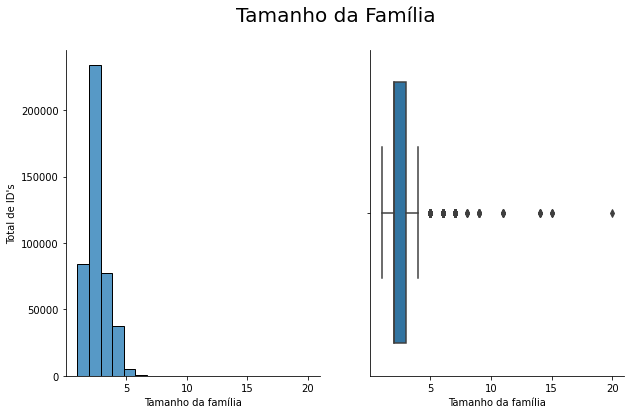

In [ ]:
#Tamanho_familia
fig, ax = plt.subplots(1,2, figsize=(10,6))

ax[0] = sns.histplot(ax=ax[0], data=cadastrados_unique, x='tamanho_familia',bins=20)
ax[1] = sns.boxplot(ax=ax[1], data=cadastrados_unique, x='tamanho_familia')
ax[0].set_xlabel('Tamanho da família')
ax[0].set_ylabel("Total de ID's")
ax[1].set_xlabel('Tamanho da família')
plt.suptitle('Tamanho da Família', fontsize=20)
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

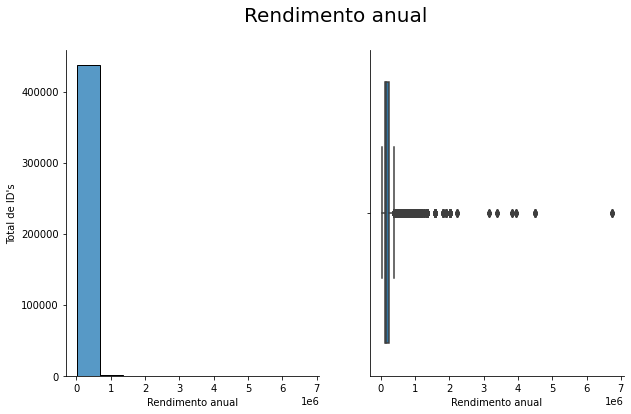

In [ ]:
#Rendimento anual
fig, ax = plt.subplots(1,2, figsize=(10,6))

ax[0] = sns.histplot(ax=ax[0], data=cadastrados_unique, x='rendimento_anual', bins=10)
ax[1] = sns.boxplot(ax=ax[1], data=cadastrados_unique, x='rendimento_anual')
ax[0].set_ylabel("Total de ID's")
ax[0].set_xlabel('Rendimento anual')
ax[1].set_xlabel('Rendimento anual')
plt.suptitle('Rendimento anual', fontsize=20)
sns.despine()
plt.show()

No rendimento anual podemos perceber que há muitos outliers principalmente até 2e6 que estão distorcendo a média e a mediana.

In [ ]:
#tratando outliers no rendimento anual
#uma forma usual de tratar outliers é a de excluir todos aqueles que estiverem a dois desvio-padrão da média.
#Porém nesse caso, pensando no negócio, excluir clientes com muita alta renda não é a melhor forma, por isso vamos substituir os valores pela mediana.

media_rendimentos = cadastrados_unique['rendimento_anual'].mean()
std_rendimentos = cadastrados_unique['rendimento_anual'].std()

lista_outliers = [ index for index,valor in cadastrados_unique['rendimento_anual'].items() 
                  if valor > (media_rendimentos+(2*std_rendimentos)) 
                  or valor < (media_rendimentos-(2*std_rendimentos))
                  ]
len(lista_outliers)

12641

In [ ]:
#substituindo pela mediana
cadastrados_clean_v1 = cadastrados_unique.copy()
cadastrados_clean_v1.loc[lista_outliers,'rendimento_anual'] = cadastrados_clean_v1['rendimento_anual'].median()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

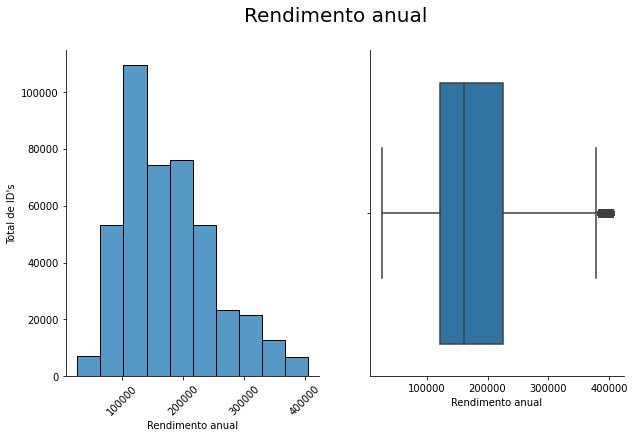

In [ ]:
#Rendimento anual corrigido
fig, ax = plt.subplots(1,2, figsize=(10,6))

ax[0] = sns.histplot(ax=ax[0], data=cadastrados_clean_v1, x='rendimento_anual', bins=10)
ax[1] = sns.boxplot(ax=ax[1], data=cadastrados_clean_v1, x='rendimento_anual')
ax[0].set_ylabel("Total de ID's")
ax[0].set_xlabel('Rendimento anual')
ax[1].set_xlabel('Rendimento anual')
ax[0].tick_params('x', rotation=45)
plt.suptitle('Rendimento anual', fontsize=20)
sns.despine()
plt.show()

##Aprofundando a análise exploratória

---
Vamos agora observar melhor as váriaveis categóricas e também combinar com algumas quantitativas.


In [ ]:
categorical_columns

['categoria_de_renda',
 'estado_civil',
 'moradia',
 'ocupacao',
 'grau_escolaridade']

In [ ]:
def plota_countplot(eixo_x: pd.Series, titulo: str, xlabel: str, paleta:'mpl_colormap'='Set1', order=None):
  """ Função para visualizar as variáveis categóricas do dataset 
  """
  fig, ax = plt.subplots(figsize=(14,6))
  sns.countplot(ax=ax, x=eixo_x, palette=paleta, order=order)
  ax.set_title(titulo, fontsize=14)
  ax.set_xlabel(xlabel, fontsize=11)
  ax.set_ylabel("Total de ID's", fontsize=11)
  
  plt.tick_params('x', rotation=45)
  sns.despine()
  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

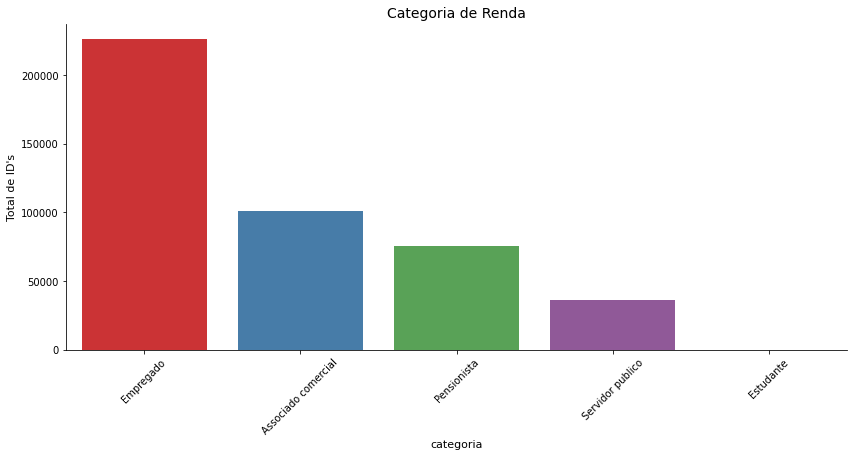

In [ ]:
plota_countplot(cadastrados_clean_v1['categoria_de_renda'], 'Categoria de Renda', 'categoria')

A maioria dos clientes são empregados, o que segue o padrão esperado de que a maioria das pessoas sejam empregadas, uma visão interessante seria se tivessémos um divisão desses empregados entre informais e formais.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

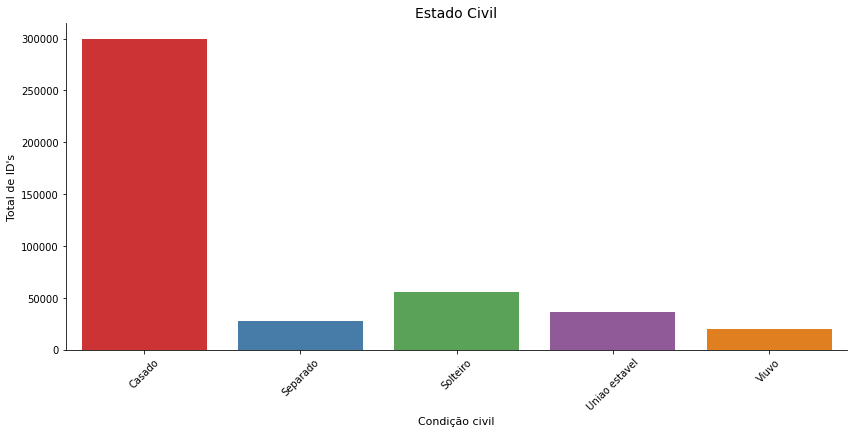

In [ ]:
plota_countplot(cadastrados_clean_v1['estado_civil'].sort_values(), 'Estado Civil', 'Condição civil')

Maioria absoluta dos clientes são casados.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

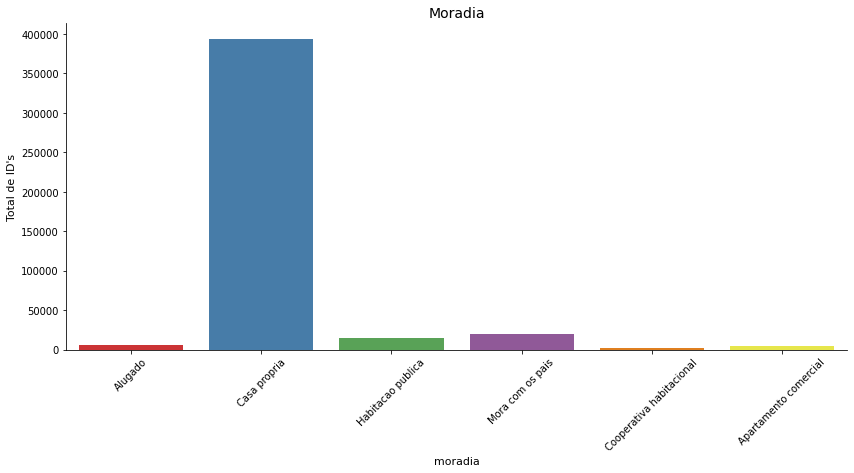

In [ ]:
plota_countplot(cadastrados_clean_v1['moradia'], 'Moradia', 'moradia')

Esse dado é importante para o negócio, novamente uma sub-divisão seria boa, casa própria quitada ou eles tem parte da renda comprometida por parcelas (quase equivalente ao comprometimento de renda com aluguel)?

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

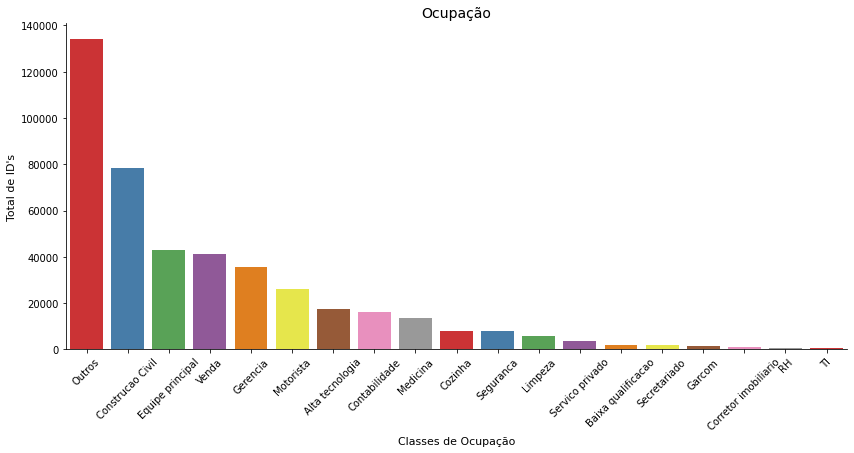

In [ ]:
plota_countplot(cadastrados_clean_v1['ocupacao'], 'Ocupação', 'Classes de Ocupação',
                order=cadastrados_clean_v1['ocupacao'].value_counts().index)

A maioria dos clientes forneceram a classe "Outros" como Ocupação, vamos investigar o que isso pode significar:

Temos uma hipótese:
 
 - São outras profissões que não se estão disponíveis (como educação) e os pensionistas;

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

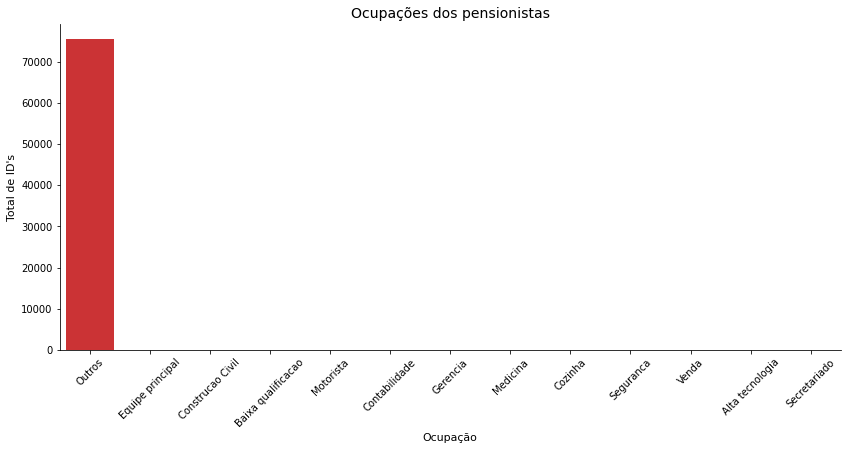

In [ ]:
df_pensionistas = cadastrados_clean_v1.query("categoria_de_renda == 'Pensionista'")
plota_countplot(df_pensionistas['ocupacao'], 'Ocupações dos pensionistas', 'Ocupação')

Como suspeitamos de cerca de 120 mil "Outros" mais de 50% são os pensionistas.

Agora sobre as outras profissões vamos olhar a distribuição salarial da base toda com a distribuição dos outros (exceto os pensionistas).

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

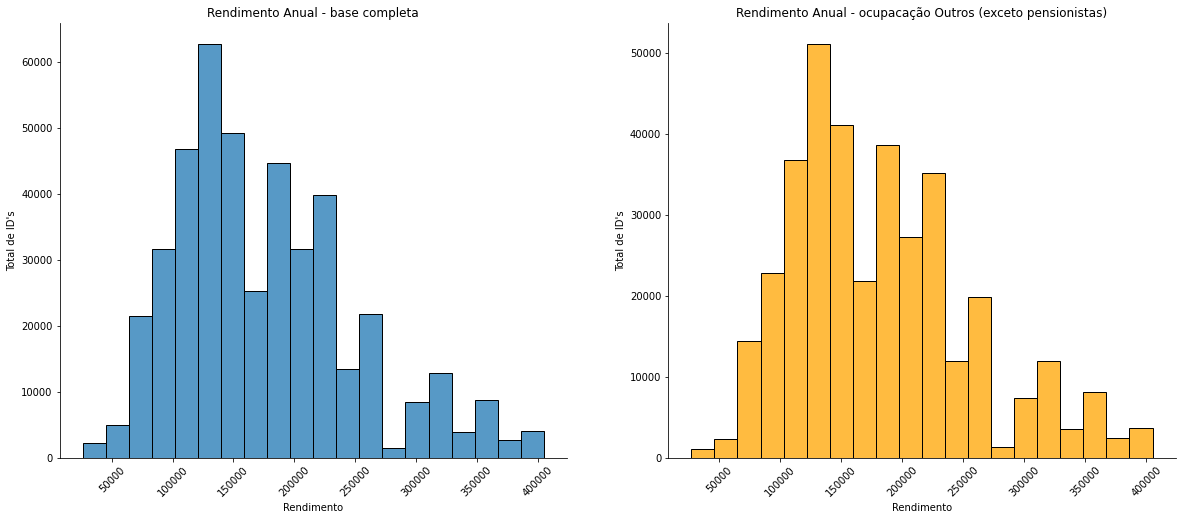

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

df_sem_pensionistas = cadastrados_clean_v1[cadastrados_clean_v1['categoria_de_renda'] != 'Pensionista']

sns.histplot(ax=ax[0], data=cadastrados_clean_v1, x='rendimento_anual', bins=20)
sns.histplot(ax=ax[1], data=df_sem_pensionistas, x='rendimento_anual', bins=20, color='orange')

ax[0].set_title('Rendimento Anual - base completa')
ax[0].set_xlabel('Rendimento')
ax[0].set_ylabel("Total de ID's")
ax[0].tick_params('x',rotation=45)

ax[1].set_title('Rendimento Anual - ocupacação Outros (exceto pensionistas)')
ax[1].set_xlabel('Rendimento')
ax[1].set_ylabel("Total de ID's")
ax[1].tick_params('x',rotation=45)

sns.despine()
plt.show()

A distribuição é quase idêntica, confirmando que são várias outras profissões não cobertas pelas opções disponíveis.

###Observando as colunas binárias

In [ ]:
cat_binary_columns

['tem_carro',
 'tem_casa_propria',
 'tem_telefone_trabalho',
 'tem_telefone_fixo',
 'tem_email']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

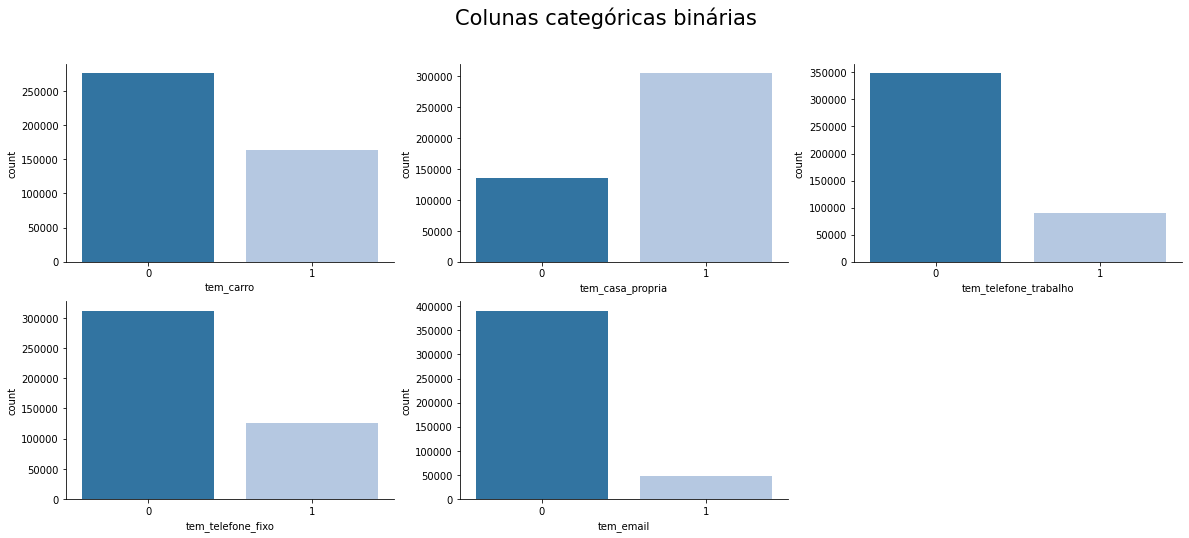

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20,8))

palette = sns.color_palette('tab20')
ax[0,0] = sns.countplot(ax=ax[0,0], data=cadastrados_clean_v1, x='tem_carro',palette=palette)
ax[0,1] = sns.countplot(ax=ax[0,1], data=cadastrados_clean_v1, x='tem_casa_propria',palette=palette)
ax[0,2] = sns.countplot(ax=ax[0,2], data=cadastrados_clean_v1, x='tem_telefone_trabalho',palette=palette)
ax[1,0] = sns.countplot(ax=ax[1,0], data=cadastrados_clean_v1, x='tem_telefone_fixo',palette=palette)
ax[1,1] = sns.countplot(ax=ax[1,1], data=cadastrados_clean_v1, x='tem_email',palette=palette)
ax[1,2].xaxis.set_major_locator(ticker.NullLocator()) #apagando os eixos do último gráfico
ax[1,2].yaxis.set_major_locator(ticker.NullLocator()) #apagando os eixos do último gráfico

plt.suptitle('Colunas categóricas binárias', fontsize=21)
sns.despine()
sns.despine(ax=ax[1,2], left=True, bottom=True) #apagando os eixos do último gráfico
plt.show()

#Explorando a base de clientes aprovados

---
Esta segunda seção principal é dedicada a explorar e preparar a base de clientes aprovados - a base target do projeto.


In [ ]:
df_aprovados

,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado
...,...,...,...
1048570,5150487,-25,pagamento realizado
1048571,5150487,-26,pagamento realizado
1048572,5150487,-27,pagamento realizado
1048573,5150487,-28,pagamento realizado


In [ ]:
#transformando colunas para lowercase
df_aprovados.columns = df_aprovados.columns.str.lower()

In [ ]:
df_aprovados.info() #df não tem dados nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id_cliente      1048575 non-null  int64 
 1   mes_referencia  1048575 non-null  int64 
 2   faixa_atraso    1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


##Entendendo as colunas

In [ ]:
#Observando a coluna de ID_Cliente
df_aprovados['id_cliente'].value_counts()

5145767    61
5116236    61
5037153    61
5002523    61
5028973    61
           ..
5149044     1
5079047     1
5137258     1
5023604     1
5023029     1
Name: id_cliente, Length: 45985, dtype: int64

A coluna de ID mostra que o df não é uma linha por cliente, há clientes com até 61 linhas.

Vamos olhar o cliente 5145767 que aparece em 1º no value_counts() para entender se são repetições.

In [ ]:
df_aprovados.query("id_cliente == 5145767")

,id_cliente,mes_referencia,faixa_atraso
1004969,5145767,0,1-29 dias
1004970,5145767,-1,1-29 dias
1004971,5145767,-2,1-29 dias
1004972,5145767,-3,1-29 dias
1004973,5145767,-4,1-29 dias
...,...,...,...
1005025,5145767,-56,1-29 dias
1005026,5145767,-57,1-29 dias
1005027,5145767,-58,1-29 dias
1005028,5145767,-59,1-29 dias


O dataframe está organizando por ID então (podemos ver que o index é sequencial para o ID) e está falando de meses desde o mês 0 (atual) até X meses no passado. A coluna faixa_atraso explica a condição do cliente com o crédito naquele momento.

In [ ]:
df_aprovados['faixa_atraso'].value_counts()

pagamento realizado    442031
1-29 dias              383120
nenhum empréstimo      209230
30-59 dias              11090
>150 dias                1693
60-89 dias                868
90-119 dias               320
120-149 dias              223
Name: faixa_atraso, dtype: int64

Existem 8 classificações possíveis para o mês de referência do cliente:
- Nenhum empréstimo ativo;
- Pagamento realizado (em dia ou adiantamento);
- 1-29 dias de atraso;
- 30-59 dias de atraso;
- 60-89 dias de atraso;
- 90-119 dias de atraso;
- 120-149 dias de atraso;
- '>150 dias de atraso.

Essas faixas são uma métrica importante tanto para a saúde financeira do tomador quando para a saúde do emprestador, visto que, existem regras determinadas pelo Banco Central sobre a Provisão para Devedores Duvidosos (PDD). Em linhas gerais a PDD versa sobre que para cada faixa de atraso uma determinada quantidade do emprestado para o tomador deva ser reservada em caso de default (não pagamento), o que afeta diretamente a rentabilidade dos empréstimos.

A lógica é de quanto mais PDD mais caixa deve ser reservado para cobrir os rombos e menos dinheiro foi recebido pelos empréstimos feitos. É importante notar que a porcentagem de PDD em relação ao total do empréstimo aumenta com a rolagem de faixa - chegando a 100% do emprestado em rolagens maiores de 90 dias.

In [ ]:
cadastrados_clean_v1.query("id_cliente == 5001711 or id_cliente == 5145767")

,id_cliente,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado
32335,5145767,1,1,0,135000.0,Empregado,Ensino superior,Casado,Casa propria,42,0,0,1,Outros,2,13.2


Uma exploração rápida com alguns clientes que utilizamos para entender a base mostra que nem todos estão nos cadastrados. 

Notamos que como a base de cadastro tem ~= 425 mil clientes e a de aprovados ~=45 mil, **cerca de 10,8% tem ou teve empréstimos.**

Uma forma de começar a preparar a base target com colunas que serão usada pelo modelo para a predição é cruzar com a de cadastro e trazer as informações desses clientes que estão lá.

In [ ]:
#cruzando as bases de aprovação e cadastro
base_dados_aprovados_v1 = pd.merge(df_aprovados, cadastrados_clean_v1, how='left', on='id_cliente', sort=True)
base_dados_aprovados_v1.head()

<IPython.core.display.Javascript object>

,id_cliente,mes_referencia,faixa_atraso,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado
0,5001711,0,nenhum empréstimo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001711,-1,1-29 dias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5001711,-2,1-29 dias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5001711,-3,1-29 dias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5001712,0,pagamento realizado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Criando medidas auxiliares para chegar à binagem no dataframe de aprovados

---
Esta seção é dedicada à criarmos medidas auxiliares para o dataframe com os clientes aprovados de forma a depois conseguir diminuir sua dimensionalidade para uma coluna target binária.


In [ ]:
df_aprovados.head(3)

,id_cliente,mes_referencia,faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias


In [ ]:
#A primeira medida que criaremos é a 'abertura', métrica que vai mostrar o primeiro mês que o cliente tinha crédito na base
df_aprovados_grouped = df_aprovados.groupby("id_cliente")
column_abertura = df_aprovados_grouped.apply(lambda x: min(x['mes_referencia']))
column_abertura.name = 'abertura'
df_aprovados = df_aprovados.merge(column_abertura, on='id_cliente', how='left')
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura
0,5001711,0,nenhum empréstimo,-3
1,5001711,-1,1-29 dias,-3
2,5001711,-2,1-29 dias,-3
3,5001711,-3,1-29 dias,-3
4,5001712,0,pagamento realizado,-18


In [ ]:
#A segunda medida que criaremos é a de 'final', métrica para indicar o último mês que ele tinha crédito na base
df_aprovados_grouped = df_aprovados.groupby("id_cliente")
column_final = df_aprovados_grouped.apply(lambda x: max(x['mes_referencia']))
column_final.name = 'final'
df_aprovados = df_aprovados.merge(column_final, on='id_cliente', how='left')
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura,final
0,5001711,0,nenhum empréstimo,-3,0
1,5001711,-1,1-29 dias,-3,0
2,5001711,-2,1-29 dias,-3,0
3,5001711,-3,1-29 dias,-3,0
4,5001712,0,pagamento realizado,-18,0


In [ ]:
#A terceira métrica é justamente a Janela, a diferença entre a abertura e o final do crédito
df_aprovados['janela'] = df_aprovados['final'] - df_aprovados['abertura']
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura,final,janela
0,5001711,0,nenhum empréstimo,-3,0,3
1,5001711,-1,1-29 dias,-3,0,3
2,5001711,-2,1-29 dias,-3,0,3
3,5001711,-3,1-29 dias,-3,0,3
4,5001712,0,pagamento realizado,-18,0,18


In [ ]:
#A quarta métrica é o MOB (Months on the Book), ou a qual mês de recebimento daquele crédito estamos se referindo para fins de rentabilidade e contabilidade
#Exemplo: cliente pegou crédito em Jul/2021 (Jul/2021 é o MOB 0 então), em Setembro/2021 cliente está no MOB 2 
#O comum de se interpretar, é que os pagamentos no MOB 0 são Adiantamentos, porque geralmente o primeiro vencimento é para o próximo mês de referência
df_aprovados['MOB'] = df_aprovados['mes_referencia'] - df_aprovados['abertura']
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura,final,janela,MOB
0,5001711,0,nenhum empréstimo,-3,0,3,3
1,5001711,-1,1-29 dias,-3,0,3,2
2,5001711,-2,1-29 dias,-3,0,3,1
3,5001711,-3,1-29 dias,-3,0,3,0
4,5001712,0,pagamento realizado,-18,0,18,18


In [ ]:
#A quinta métrica é uma coluna numérica da faixa de atraso, nesta parte estamos fazendo um Label Encoding 'manual'
dict_faixa_atraso_ind ={'nenhum empréstimo': 0, 'pagamento realizado': 1,
                        '1-29 dias': 2, '30-59 dias': 3, '60-89 dias': 4,
                        '90-119 dias': 5, '120-149 dias': 6, '>150 dias': 7}
df_aprovados['faixa_atraso_num'] = df_aprovados['faixa_atraso'].map(dict_faixa_atraso_ind)
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura,final,janela,MOB,faixa_atraso_num
0,5001711,0,nenhum empréstimo,-3,0,3,3,0
1,5001711,-1,1-29 dias,-3,0,3,2,2
2,5001711,-2,1-29 dias,-3,0,3,1,2
3,5001711,-3,1-29 dias,-3,0,3,0,2
4,5001712,0,pagamento realizado,-18,0,18,18,1


In [ ]:
#A sexta métrica para o dataframe é uma coluna aqui sim binária que define uma lógica para maus pagadores
df_aprovados['mau_pagador'] = df_aprovados.apply(lambda x: 1 if x['faixa_atraso_num'] > 3 else 0, axis=1)
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura,final,janela,MOB,faixa_atraso_num,mau_pagador
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0


###Continuando a análise em busca da variável target

In [ ]:
df_registros_creditos_ID = df_aprovados[['id_cliente','abertura', 'final', 'janela']]\
                                                                                      .groupby('id_cliente')\
                                                                                      .apply(lambda x: x.iloc[0]).reset_index(drop=True)
df_registros_creditos_ID

,id_cliente,abertura,final,janela
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [ ]:
df_denominador = df_registros_creditos_ID.groupby('abertura').apply(lambda X: X['id_cliente'].count()).reset_index()
df_denominador.columns = ['abertura','qtd_clientes']
df_denominador

,abertura,qtd_clientes
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [ ]:
df_vintage = df_aprovados.groupby(['abertura','MOB']).apply(lambda X: X['id_cliente'].count()).reset_index()
df_vintage.columns = ['abertura','MOB','qtd_clientes']
df_vintage

,abertura,MOB,qtd_clientes
0,-60,0,415
1,-60,1,414
2,-60,2,410
3,-60,3,408
4,-60,4,403
...,...,...,...
1886,-2,1,770
1887,-2,2,750
1888,-1,0,686
1889,-1,1,682


In [ ]:
df_vintage = pd.merge(df_vintage[['abertura','MOB']], df_denominador, on='abertura', how = 'left')
df_vintage

<IPython.core.display.Javascript object>

,abertura,MOB,qtd_clientes
0,-60,0,415
1,-60,1,415
2,-60,2,415
3,-60,3,415
4,-60,4,415
...,...,...,...
1886,-2,1,771
1887,-2,2,771
1888,-1,0,686
1889,-1,1,686


In [ ]:
df_vintage['qtd_mau'] = np.nan

for j in range(-60,1):
    ls = []
    for i in range(0,61):
        due = list(df_aprovados.query('mau_pagador == 1 and MOB == @i and abertura == @j')['id_cliente'])
        ls.extend(due)
        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['abertura'] == j), 'qtd_mau'] = len(set(ls))
        
df_vintage['taxa_de_mau']  = df_vintage['qtd_mau'] / df_vintage['qtd_clientes']
df_vintage

<IPython.core.display.Javascript object>

,abertura,MOB,qtd_clientes,qtd_mau,taxa_de_mau
0,-60,0,415,0.0,0.000000
1,-60,1,415,0.0,0.000000
2,-60,2,415,0.0,0.000000
3,-60,3,415,0.0,0.000000
4,-60,4,415,0.0,0.000000
...,...,...,...,...,...
1886,-2,1,771,0.0,0.000000
1887,-2,2,771,1.0,0.001297
1888,-1,0,686,0.0,0.000000
1889,-1,1,686,0.0,0.000000


In [ ]:
df_vintage_pivot = df_vintage.pivot(index = 'abertura',
                             columns = 'MOB',
                             values = 'taxa_de_mau')

df_vintage_pivot

MOB,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
abertura,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.0,0.0,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.0,0.0,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0.0,0.0,0.000000,0.003432,0.003432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3,0.0,0.0,0.001088,0.001088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,0.0,0.0,0.001297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

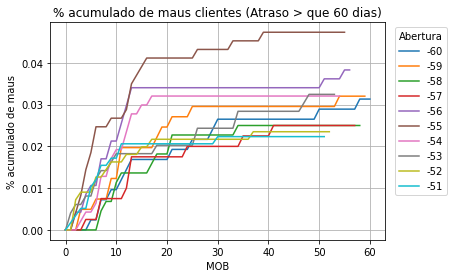

In [ ]:
lst = [i for i in range(0,61)]
df_vintage_pivot[lst].T.iloc[:,:10].plot(legend = True, grid = True, title = '% acumulado de maus clientes (Atraso > que 60 dias)')

plt.xlabel('MOB')
plt.ylabel('% acumulado de maus')
plt.legend(bbox_to_anchor=(1.2, 1), title='Abertura')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

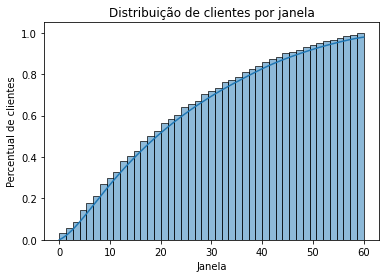

In [ ]:
sns.histplot(data=df_registros_creditos_ID, x='janela', cumulative=True, stat='density', kde=True)
plt.title('Distribuição de clientes por janela')
plt.xlabel('Janela')
plt.ylabel('Percentual de clientes')
plt.show()

In [ ]:
dict_intervalo_atraso = {'maior_30_dias': 3, 'maior_60_dias': 4, 'maior_90_dias': 5,
                        'maior_120_dias': 6, 'maior_150_dias': 7}

In [ ]:
for chave, valor in dict_intervalo_atraso.items():
  df_aprovados[f'Mau_{chave}'] = df_aprovados.apply(lambda x: 1 if x['faixa_atraso_num'] >= valor else 0, axis=1) # mais de 60
df_aprovados.head()

,id_cliente,mes_referencia,faixa_atraso,abertura,final,janela,MOB,faixa_atraso_num,mau_pagador,Mau_maior_30_dias,Mau_maior_60_dias,Mau_maior_90_dias,Mau_maior_120_dias,Mau_maior_150_dias
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0,0,0,0,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0,0,0,0,0,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0,0,0,0,0,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0,0,0,0,0,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0,0,0,0,0,0


In [ ]:
dict_taxa_mau = {}
id_sum = len(set(df_aprovados['id_cliente']))

for chave in dict_intervalo_atraso.keys():
  df_min_mau = df_aprovados.query(f'Mau_{chave} == 1').groupby('id_cliente')['MOB'].min().reset_index()
  df_mob_taxa_mau = pd.DataFrame({'MOB':range(0,61), 'taxa_mau': np.nan})
  lst = []
  for i in range(0,61):
      due = df_min_mau.query('MOB == @i')['id_cliente'].to_list()
      lst.extend(due) #cumsum
      df_mob_taxa_mau.loc[df_mob_taxa_mau['MOB'] == i, 'taxa_mau'] = len(set(lst)) / id_sum
  dict_taxa_mau[chave] = df_mob_taxa_mau['taxa_mau']

df_taxa_mau = pd.DataFrame(dict_taxa_mau)
df_taxa_mau

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,maior_30_dias,maior_60_dias,maior_90_dias,maior_120_dias,maior_150_dias
0,0.000304,0.000022,0.000022,0.000022,0.000022
1,0.011612,0.000174,0.000087,0.000087,0.000087
2,0.025878,0.001153,0.000196,0.000174,0.000174
3,0.036860,0.002240,0.000696,0.000304,0.000304
4,0.047385,0.003392,0.001044,0.000696,0.000348
...,...,...,...,...,...
56,0.116321,0.014483,0.007176,0.005263,0.004219
57,0.116321,0.014483,0.007176,0.005263,0.004219
58,0.116321,0.014505,0.007198,0.005284,0.004241
59,0.116321,0.014505,0.007198,0.005284,0.004241


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

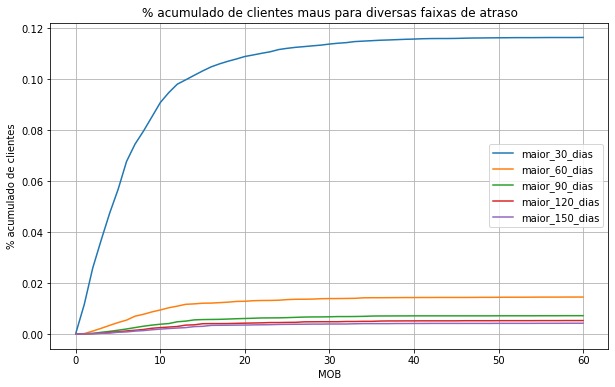

In [ ]:
df_taxa_mau.plot(grid = True, title = '% acumulado de clientes maus para diversas faixas de atraso', figsize=(10, 6))
plt.xlabel('MOB')
plt.ylabel('% acumulado de clientes')
plt.show()

In [ ]:
df_aprovados_v2 = df_aprovados.query('janela >= 12').copy()

In [ ]:
def verifica(registros):
  lista_status = registros['faixa_atraso'].to_list()
  if '60-89 dias' in lista_status or '90-119 dias' in lista_status or '120-149 dias' in lista_status or '>150 dias' in lista_status:
    return 1
  else:
    return 0
  
df_registros_creditos_id = pd.DataFrame(df_aprovados_v2.groupby('id_cliente').apply(verifica)).reset_index()
df_registros_creditos_id.columns = ['id_cliente', 'mau']
df_registros_creditos_id.head()

<IPython.core.display.Javascript object>

,id_cliente,mau
0,5001712,0
1,5001713,0
2,5001714,0
3,5001715,0
4,5001717,0


In [ ]:
#versão final concluída da base com features e target
df_registro_clientes_targets = cadastrados_clean_v1.merge(df_registros_creditos_id, on='id_cliente')
df_registro_clientes_targets.head()

,id_cliente,tem_carro,tem_casa_propria,qtd_filhos,rendimento_anual,categoria_de_renda,grau_escolaridade,estado_civil,moradia,idade,tem_telefone_trabalho,tem_telefone_fixo,tem_email,ocupacao,tamanho_familia,anos_empregado,mau
0,5008804,1,1,0,161100.0,Empregado,Ensino superior,Uniao estavel,Alugado,33,1,0,0,Outros,2,12.4,0
1,5008805,1,1,0,161100.0,Empregado,Ensino superior,Uniao estavel,Alugado,33,1,0,0,Outros,2,12.4,0
2,5008806,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59,0,0,0,Seguranca,2,3.1,0
3,5008810,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52,0,1,1,Venda,1,8.4,0
4,5008811,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52,0,1,1,Venda,1,8.4,0


In [ ]:
df_registro_clientes_targets['mau'].value_counts(normalize=True)*100

0    97.71126
1     2.28874
Name: mau, dtype: float64

Apesar de todos nossos tratamentos, podemos ver que o target ficou muito desbalanceado, o que não é o ideal, e teremos que tratar isso.

Agora, após a conclusão da parte analítica e de preparação da base, iremos para outro notebook para a seção de aplicação do Machine Learning.

Acesse o próximo notebook aqui (inserir link depois).

In [ ]:
df_registro_clientes_targets.to_csv('df_registro_clientes_targets.csv', sep=',', encoding='utf-8')